In [1]:
!pip install pandahouse

  Preparing metadata (setup.py) ... done
  Created wheel for pandahouse: filename=pandahouse-0.2.7-py2.py3-none-any.whl size=5904 sha256=02bdaca3831d5203f39757e691da8f851f047dbfbbf8a72acd08518047ceba9b
  Stored in directory: /root/.cache/pip/wheels/04/81/63/6896730711da10812121737bb505c6a8993800e99d39432522
Successfully built pandahouse


In [2]:
import pandas as pd

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Задача
Мы наблюдаем внезапное падение активной аудитории! Нужно разобраться, какие пользователи не смогли воспользоваться лентой новостей, что их объединяет?

# Решение

In [3]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240320'
}
db='simulator_20240320'

In [4]:
q = f"""
SELECT
  DATE(time) AS date,
  COUNT(DISTINCT user_id) DAU
FROM {db}.feed_actions
GROUP BY date
ORDER BY date
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,date,DAU
0,2024-02-03,878
1,2024-02-04,2238
2,2024-02-05,3105
3,2024-02-06,3721
4,2024-02-07,4617


In [5]:
px.line(df, x='date', y='DAU')

In [6]:
q = f"""
SELECT
  DATE(time) AS date,
  COUNT(DISTINCT user_id) DAU
FROM {db}.feed_actions
WHERE date = toDate('2024-03-23')
GROUP BY date
"""

pandahouse.read_clickhouse(q, connection=connection)

,date,DAU
0,2024-03-23,14073


Провал пользователей произошёл 23.03.2024

In [7]:
target_date = "toDate('2024-03-23')"

## Возможные причины

Необходимо посчитать retention на следующий день

<Axes: xlabel='date', ylabel='retention'>

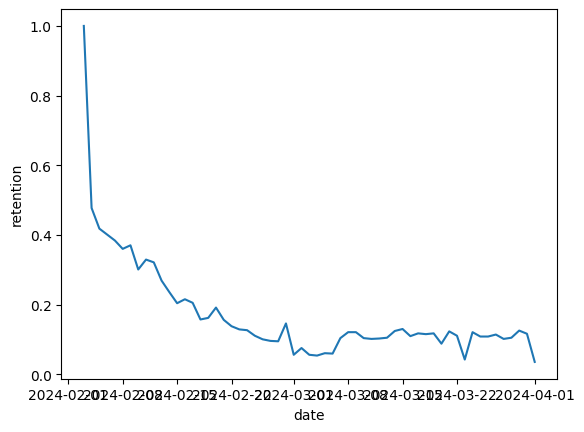

In [8]:
# retention для одной когорты
q = f"""
WITH t_segment_users AS (
  SELECT DISTINCT user_id
  FROM {db}.feed_actions
  WHERE DATE(time) = toDate('2024-02-3')
),
t_retention_1 AS (
  SELECT
  DATE(time) AS date,
    COUNT(DISTINCT user_id) AS uniq_users
  FROM {db}.feed_actions
  WHERE user_id IN t_segment_users
  GROUP BY date
),
t_retention_2 AS (
  SELECT
    date,
    uniq_users,
    MAX(uniq_users) OVER () AS uniq_users_day_0
  FROM t_retention_1
),
t_retention AS (
  SELECT
    date,
    uniq_users / uniq_users_day_0 AS retention
  FROM t_retention_2
)

SELECT *
FROM t_retention
"""

# pandahouse.read_clickhouse(q, connection=connection)
sns.lineplot(pandahouse.read_clickhouse(q, connection=connection), x='date', y='retention')

In [79]:
# retention для всех когорт (с фильтрацией в диапазоне 2024-03-23)
q = f"""
WITH t_users_actions AS (
  -- Действия пользователям по дням
  SELECT DISTINCT
    user_id,
    DATE(time) AS date
  FROM {db}.feed_actions
  WHERE date BETWEEN toDate('2024-03-23')-8 AND toDate('2024-03-23')+3
),
t_cohorts AS (
  -- Когорты пользователей
  SELECT
    user_id,
    date,
    MIN(date) OVER (
      PARTITION BY user_id
    ) AS cohort
  FROM t_users_actions
),
t_retention_1 AS (
  -- Количество когортных пользователей по периодам
  SELECT
    COUNT(DISTINCT user_id) AS uniqs,
    cohort,
    date
  FROM t_cohorts
  GROUP BY cohort, date
),
t_retention_2 AS (
  -- Количество пользователей в day_0 для когорт
  SELECT
    uniqs,
    cohort,
    date,
    MAX(uniqs) OVER (
      PARTITION BY cohort
    ) AS uniqs_day_0,
    date - cohort as dt
  FROM t_retention_1
),
t_retention AS (
  SELECT
    ROUND(uniqs / uniqs_day_0 * 100) AS metric,
    cohort,
    dt,
    date
  FROM t_retention_2
)


SELECT *
FROM t_retention
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.metric = df.metric.apply(lambda x: int(x))
df.cohort = df.cohort.apply(lambda x: str(x)[6:11])
df.date = df.date.apply(lambda x: str(x)[6:11])

max_el = max(el for el in df.metric if el != 100)

df = df.pivot(index='cohort', columns='date', values='metric')
 # heatmap
cm = sns.color_palette("magma", as_cmap=True)
df = (
    df
    .style
    .background_gradient(
        cmap=cm,
        axis=None,
        vmax=max_el
    )
    .format('{:.0f}')
    .applymap(lambda x: 'color: transparent' if pd.isnull(x) else '')
    .highlight_null('white')
)
df

date,3-15,3-16,3-17,3-18,3-19,3-20,3-21,3-22,3-23,3-24,3-25,3-26
cohort,,,,,,,,,,,,
3-15,100,24,23,22,21,19,19,18,13,17,16,15
3-16,nan,100,24,23,22,20,19,19,13,17,17,15
3-17,nan,nan,100,23,22,21,21,19,13,18,16,16
3-18,nan,nan,nan,100,25,23,23,21,14,21,19,18
3-19,nan,nan,nan,nan,100,23,22,20,15,18,18,18
3-20,nan,nan,nan,nan,nan,100,25,23,18,22,20,21
3-21,nan,nan,nan,nan,nan,nan,100,19,16,16,16,16
3-22,nan,nan,nan,nan,nan,nan,nan,100,15,16,16,15
3-23,nan,nan,nan,nan,nan,nan,nan,nan,100,25,27,23


Как можно заметить:
- для всех когорт 23.03.2024 наблюдается сниженный retention

Возможно, определённая категория пользователей в этот день не смогла зайти

#### 1) ОС

In [10]:
q = f"""
  SELECT DISTINCT os
  FROM {db}.feed_actions
"""

pandahouse.read_clickhouse(q, connection=connection)

,os
0,Android
1,iOS
